This homework will cover chapters 3-4 in the KEB textbook, including material on probability and random vectors. Using neural data recorded in a mouse running on a wheel, we will compute means, standard deviations, correlations, and linear fits to data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data

First we will download the data from the following paper by Stringer et al:
https://science.sciencemag.org/content/364/6437/eaav7893.abstract

This dataset has Ca2+ imaging data from 10,000 neurons in visual cortex in mice. The recordings are of spontaneous activity; there is no visual stimulus. The mouse performs locomotion, whisking, and grooming behaviors. This dataset was featured as part of the 2020 Neuromatch Academy global online summer school for computational neuroscience, and there is a video with some explanation of the dataset here:
https://www.youtube.com/watch?v=78GSgf6Dkkk

To begin, we download the data from online and save it locally. The following block of code only needs to be run once in order to create the `.npy` file.

In [2]:
#@title Data retrieval
import os, requests

url = "https://osf.io/dpqaj/download"  # where to get the data
fname = "stringer_spontaneous.npy"  # where to save the data

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)  # save the data

Next we load the data from the file we created into a dictionary called `dat`.

In [3]:
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()

# Print the keys to see what is in dat:
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


Here are descriptions of all of the types of data contained in `dat`:

* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data. Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

We will use this data for some of the exercises below.

**Exercise 1 (Calculation)**

We learned that the variance of a random variable $X$ is given by $\sigma^2 = E([X - E(X)]^2)$, where the expectation $E$ is given by $E(x) = \sum_x p(x) x$ for discrete variables or $E(x) = \int dx p(x) x$ for continuous variables. 

Show that $\sigma^2 = E(X^2) - E(X)^2$. You can either type your solution in the box below if you know LaTex, or submit a PDF of a typed or handwritten solution.

**Exercise 2 (Calculation)**

The uniform probability distribution has a constant value in some region and zero probability outside of that region. We can write this as
$$
p(x) = \begin{cases}
\frac{1}{b}, \quad\text{if}~0<x<b \\
0, \quad\text{if}~x<0~\text{or}~x>b
\end{cases}
$$
Compute the mean and the variance for this probability distribution.

# Calculating the mean and standard deviation of pupil area

One of the variables included in the data is the mouse's pupil area. As described above, each element of the array `dat['pupilArea']` is the area of the pupil in one time bin, where each time bin is 1.2s long. 

There are different ways that we can visualize this data. One way is as a time series. Here we need to define an array of time values corresponding to each data point so that the x axis has meaningful units. We give the units on the y axis as "a.u.", or "arbitrary units", because the area is measured in video pixels rather than in physically meaningful units.

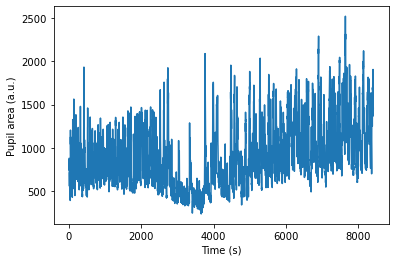

In [4]:
n_timesteps = len(dat['pupilArea'])  # The number of timesteps
t = np.arange(n_timesteps)*1.2

plt.plot(t, dat['pupilArea']);
plt.xlabel('Time (s)');
plt.ylabel('Pupil area (a.u.)');

Next, let's plot a histogram of all of the pupil area data from all of the observed times.

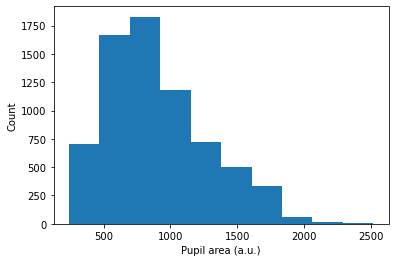

In [5]:
plt.hist(dat['pupilArea']);
plt.xlabel('Pupil area (a.u.)');
plt.ylabel('Count');

How can we summarize this data? A good way to start is by computing the **mean** (i.e. the average value) and **standard deviation** (a measure of how spread out the data is). Roughly what values do you expect the mean and standard deviation to take? Below we'll calculate them and see how close your guess was.

**Exercise 3**

Calculate the mean $\mu$ and standard deviation $\sigma$ for the pupil area data above using the defining formulas:
$$
\mu = \frac{1}{N} \sum_{i=1}^N X_i
$$
and
$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (X_i - \mu)^2},
$$
where $X_i$ is the pupil area at time step $i$. The sums can be performed using the function `np.sum()`.

After calculating these quantities, use the built-in functions `np.mean()` and `np.std()` and make sure that these give the same result.

**Solution**

In [6]:
### Your code here ###

# Relating pupil diameter to running speed

Let's plot the mouse's running speed as a function of time.

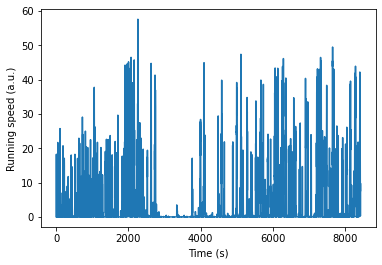

In [7]:
plt.plot(t, dat['run']);
plt.xlabel('Time (s)');
plt.ylabel('Running speed (a.u.)');

It looks like there are a lot of times when the running speed is zero, i.e. the mouse isn't moving. What fraction of the time is the mouse not moving? We can compute this by creating an array of True and False entries corresponding to whether the speed is below some threshold (we'll use 1 as the threshold), then summing all of the entries in the array (in which case True counts as 1 and False as 0). The result is

In [8]:
np.sum(dat['run'] < 1)/n_timesteps

0.7286976346537475

**Exercise 4**

1. Use a mask and fancy indexing (see our earlier NumPy tutorial for a review) to create a new array consisting of the elements of `dat['run']` in which the running speed is greater than 1. Use the same mask to also create a new array consisting of the elements of `dat['pupilArea']` at times when the running speed is greater than 1.

2. With these new arrays, make a scatter plot of points with the running speed on the x axis and the pupil area on the y axis.

**Solution**

In [9]:
### Your code here ###

It looks like there might be a relationship between these two variables, with pupil area increasing as running speed increases. In order to quantify the relationship, let's calculate the correlation coefficient.

The Pearson correlation coefficient between variables $X$ and $Y$ is defined as 
$$
\rho = \frac{\frac{1}{N} \sum_{i=1}^N (X_i - \mu_X)(Y_i - \mu_Y)}{\sigma_X \sigma_Y},
$$
where $\mu_X$, $\mu_Y$, $\sigma_X$, and $\sigma_Y$ are the means and standard deviations of the individual variables, as defined above.

**Exercise 5**

1. Using the arrays that we created in the previous exercise that consist of the pupil area and the running speed during times when the mouse is running, calculate the correlation coefficient using the above formula. (If you weren't able to get these arrays in the previous exercise, just use the original arrays that include all time points.)

2. Calculate the correlation coefficient using the built-in function `np.corrcoef()` and check that it agrees with the above result. Note that the function returns a matrix rather than a scalar value. The correlation coefficient that we want will be the off-diagonal element of this matrix. You can read the function's documentation (just type `np.corrcoef?`) to understand what the matrix is.

**Solution**

In [10]:
### Your code here ###

In class we showed that linear fit that minimizes the mean squared error is given by $y = \alpha + \beta x$, where $\beta = \rho \sigma_Y / \sigma_X$, and $\alpha = \mu_Y - \beta \mu_X$. Below we will calculate these coefficients and plot the linear fit.

**Exercise 6**

1. Calculate $\alpha$ and $\beta$ using the results from the previous exercise and plot the straight line $y = \alpha + \beta x$ along with the data.

2. Use the built-in function `np.polyfit()` to obtain $\alpha$ and $\beta$ and compare with the values obtained above. (Read the documentation to see how this function works.)

3. Make a plot that shows both a scatter plot of the data and the linear fit calculated with the coefficients $\alpha$ and $\beta$.

**Solution**

In [11]:
### Your code here ###

# Neural activity

Recall from above that `dat['sresp']` is an array containing the time-dependent activity of all neurons. We'll analyze this part of the data in what follows. To get a sense of what the data looks like, we can start by plotting the activity of the first few neurons over the first couple minutes of recording.

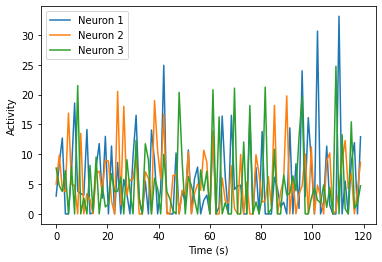

In [12]:
plt.plot(t[:100], dat['sresp'][:3,:100].T)

plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.legend(['Neuron 1', 'Neuron 2', 'Neuron 3'])

**Exercise 7**

1. Create a new array, `mean_activity`, of the mean neural activity, where each element of the array is the activity of one neuron averaged over all time points. You may want to read the documentation of `np.mean()` to remind yourself of how to take the mean over one dimension of a two-dimensional array.

2. Plot a histogram of the mean activity and compute the mean and standard deviation of the activities in `mean_activity`.

**Solution**

In [13]:
### Your code here ###

# Computing correlations between neurons

How correlated are the neurons with one another? Let's take a look.

**Exercise 8**

Use `np.corrcoef()` to compute a matrix of correlations between each pair of the first 100 neurons in the data. Use `plt.imshow()` to display the matrix of correlations between all pairs of these first 100 neurons. Remember to label the axes and include a color bar to show what the colors mean.

**Solution**

In [14]:
### Your code here ###

**Exercise 9**

Note that the above matrix is symmetric since the correlation of neuron $i$ with neuron $j$ is the same as the correlation of neuron $j$ with neuron $i$. (You can look back at the definition of the the correlation coefficient $\rho$ above to check that this is true.) Note also that the diagonal elements aren't really meaningful, since a neuron's correlation with itself is always 1.

Make a histogram of the correlations between the pairs of neurons computed above. Make sure that each correlation is only counted once and that diagonal elements in the correlation matrix aren't counted. Also compute and print the mean and standard deviation of the correlations.

**Solution**

In [15]:
### Your code here ###

# Correlation and distance

One interesting question to ask is whether neurons that are closer together tend to be more correlated with one another. Below we show that there doesn't seem to be a very strong relationship between these quantities.

In [16]:
# The 3D coordinates of each neuron are given in dat['xyz']:
np.shape(dat['xyz'])

(3, 11983)

**Exercise 10**

Using the first 100 neurons as above, calculate the distance between each pair of neurons. Using this and your solution to the previous exercise, make a scatter plot of correlation vs. distance, where each point corresponds to one pair of neurons.

**Solution**

In [17]:
### Your code here ###

**Exercise 11**

Just as we did for the pupil area and running speed above, calculate the correlation coefficient and plot the optimal linear fit to the above data.

**Solution**

In [18]:
### Your code here ###